**Last Updated 18/8/2023:**

The goal of this notebook is to find a way to be able to train models concurrently in the same notebook to maximize efficiency when training an ensemble model for deployment.

# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2
                                                                                                                                                
import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-08-21 16:33:17.331630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-21 16:33:17.561244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-21 16:33:17.562940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-01-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = 0.1
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.1 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-01-01 2023-06-01 2023-06-01 2023-07-01


# Load Data and Train NN

In [4]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [219]:
%time processed_data = load_data_from_pickle('processed_data_2023-08-21-14:53.pkl', bucket = 'ficc_training_data_latest') #load_data_from_pickle('processed_data_2023-07-24-14:53.pkl', 'ficc_training_data_latest')

File available, loading pickle
CPU times: user 26.1 s, sys: 5.73 s, total: 31.8 s
Wall time: 31.8 s


In [220]:
processed_data.trade_history.apply(lambda x: x.shape).value_counts()

(5, 6)    5644799
Name: trade_history, dtype: int64

In [221]:
processed_data.target_attention_features.apply(lambda x: x.shape).value_counts()

(1, 3)    5644799
Name: target_attention_features, dtype: int64

In [222]:
processed_data.sort_values('trade_datetime', inplace=True)

## Checking data

In [223]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-08-15 00:00:00'))

In [224]:
processed_data[['yield','new_real_time_ficc_ycl']].describe()

,yield,new_real_time_ficc_ycl
count,5644799.000,5607286.000
mean,354.967,308.641
std,90.827,51.390
min,0.100,222.526
25%,295.100,272.547
50%,341.500,301.120
75%,408.300,328.782
max,9892.500,559.034


In [225]:
processed_data.reset_index(drop=True, inplace=True)

In [229]:
def process_data(data): 
    # data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    
    # if 'yield_spread' in PREDICTORS: 
    #     PREDICTORS.remove('yield_spread')
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    
    return data

In [230]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [231]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 2min 53s, sys: 24.7 s, total: 3min 18s
Wall time: 5min 46s


In [232]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 1.61 s, sys: 114 ms, total: 1.73 s
Wall time: 1.73 s


In [233]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 50.5 s, sys: 17.6 s, total: 1min 8s
Wall time: 1min 14s


In [234]:
%%time 

processed_data = process_data(processed_data)

CPU times: user 59.1 s, sys: 21.7 s, total: 1min 20s
Wall time: 1min 30s


In [235]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
#these harm accuracy so we delete them 
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [236]:
%%time
TRADE_SEQUENCE_LENGTH = 5 
processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 3.62 s, sys: 156 ms, total: 3.78 s
Wall time: 3.78 s


In [237]:
processed_data['trade_history_shortened'].apply(lambda x: x.shape).value_counts()

(5, 6)    5129063
Name: trade_history_shortened, dtype: int64

In [238]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-08-15 00:00:00'), 5129063)

In [239]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [241]:
# train_start = '2023-01-01'
# train_end = '2023-06-01'
# test_start = '2023-06-01'
# test_end = '2023-07-01'

train_start = processed_data.trade_date.min().strftime('%Y-%m-%d')
train_end = processed_data.trade_date.max().strftime('%Y-%m-%d')

In [243]:
# train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
# test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)

train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= train_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-08-14 00:00:00
Test data start: 2023-08-15 00:00:00, end: 2023-08-15 00:00:00


In [244]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:

        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)

    
    ### CONCATENATE EMBEDDINGS
    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)


    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def generate_bottleneck_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        # if f in ['moodys_rating','rating']:
        #     continue
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx



In [245]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [246]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []

In [251]:
VALIDATION_SPLIT = 0.05

In [253]:
# params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(
    train_dataframe,                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, 
                                                                                                         yield_history_cols)

TRAINING DATA: N = 4835362, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-08-14 00:00:00
VALIDATION DATA: N = 254492, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-08-14 00:00:00
TEST DATA: N = 39209, MIN DATE = 2023-08-15 00:00:00, MAX DATE = 2023-08-15 00:00:00


In [254]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape)

14
(4835362, 5, 6)
(4835362, 1, 3)
(4835362, 48)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)
(4835362,)


In [255]:
shuffle = True
shuffle_buffer = 0.75

TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
yield_history_cols = params.get('yield_history_cols')
yield_history_lengths = params.get('yield_history_lengths')
num_yield_history = params.get('num_yield_history')

yield_history_normalizers = normalizers.get('yield_history_normalizers')
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')

tf.keras.utils.set_random_seed(10)

timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')

with tf.device('/cpu:0'):
    train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
    val_ds = create_tf_data(x_val, y_val, shuffle = False)
    val_ds = val_ds.batch(5000).prefetch(2).cache()

In [276]:
tf.keras.backend.clear_session()
gc.collect()

ENSEMBLE_SIZE = 2
models = []
for i in range(ENSEMBLE_SIZE):
    if i < ENSEMBLE_SIZE/2:
        models.append(generate_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                           yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer))
    else:
        models.append(generate_bottleneck_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                           yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer))

ERROR! Session/line number was not unique in database. History logging moved to new session 960


The key to training the model concurrently is simple to pass multiple loss functions when the model is being compiled. We have a single input layer and multiple outputs, and the target variable is mapped to all the outputs to calculate their respective errors. 

In [277]:
input_layer = models[0].input
ensemble_model = keras.Model(inputs = input_layer, outputs = [model(input_layer) for model in models])

ensemble_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                 loss=[keras.losses.MeanAbsoluteError() for i in range(ENSEMBLE_SIZE)])

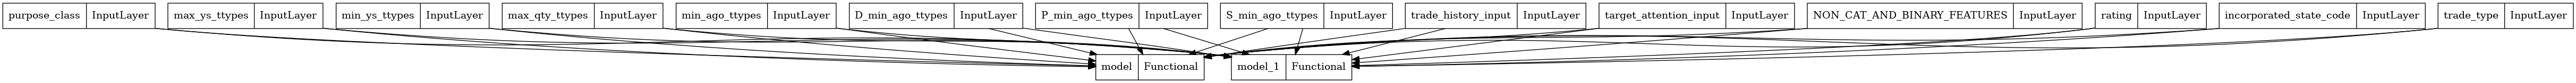

In [278]:
keras.utils.plot_model(ensemble_model)

In [280]:
#!pip install gpustat
from tensorflow.keras.callbacks import Callback
import regex as r
import gpustat

class LossCallback(Callback):
    def on_epoch_begin(self, batch, logs={}):
        super().on_epoch_begin(batch)
        self.gpu_usage = []
        
    def on_train_batch_end(self, batch, logs={}):  
        if batch % 25 == 0:
            s = str(gpustat.new_query()[0])
            gpu_usage = int(r.findall('[0-9]+ %', s)[0].split('%')[0])
            self.gpu_usage.append(gpu_usage)
        
    def on_epoch_end(self, epoch, logs=None):
        s = str(gpustat.new_query()[0])
        gpu_mem = r.findall('[0-9]+ / [0-9]+', s)[0].replace(' ', '')
        
        if logs is None:
            logs = {}
        train_loss = []
        val_loss = []
        for i in range(ENSEMBLE_SIZE):
            if i == 0:
                train_loss.append(logs.get(f'model_loss', None))
                val_loss.append(logs.get(f'val_model_loss', None))
            else:
                train_loss.append(logs.get(f'model_{i}_loss', None))
                val_loss.append(logs.get(f'val_model_{i}_loss', None))
        
        if train_loss and val_loss:
            # print(f'Epoch {epoch + 1}')
            df = pd.DataFrame([train_loss, val_loss], 
                              index = ['Train loss', 'Val loss'],
                              columns = [f'Ensemble_model_{i+1}' for i in range(ENSEMBLE_SIZE)])
            df['GPU MEMORY'] = gpu_mem
            df['MAX GPU USAGE'] = str(max(self.gpu_usage))+'%' if self.gpu_usage else None
            display(df)
            print()
            
loss_callback = LossCallback()

fit_callbacks = [
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True),
    CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False),
    loss_callback]

In [ ]:
history = ensemble_model.fit(train_ds,
                                  validation_data=val_ds,
                                    epochs=75,     
                                    verbose=1, 
                                    callbacks=fit_callbacks,
                                    use_multiprocessing=True,
                                    workers=8)

Epoch 1/75


2023-08-21 19:15:36.965819: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-21 19:15:36.966030: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

4836/4836 [==============================] - ETA: 0s - loss: 45.4315 - model_loss: 32.7675 - model_1_loss: 12.6641

2023-08-21 19:18:39.027045: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-21 19:18:39.027194: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,32.768,12.664,2225/15360,60%
Val loss,12.181,9.982,2225/15360,60%



4836/4836 [==============================] - 197s 38ms/step - loss: 45.4315 - model_loss: 32.7675 - model_1_loss: 12.6641 - val_loss: 22.1636 - val_model_loss: 12.1815 - val_model_1_loss: 9.9822
Epoch 2/75
4836/4836 [==============================] - ETA: 0s - loss: 20.7849 - model_loss: 10.8954 - model_1_loss: 9.8896

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,10.895,9.890,2225/15360,59%
Val loss,9.633,9.570,2225/15360,59%



4836/4836 [==============================] - 180s 37ms/step - loss: 20.7849 - model_loss: 10.8954 - model_1_loss: 9.8896 - val_loss: 19.2033 - val_model_loss: 9.6333 - val_model_1_loss: 9.5700
Epoch 3/75
4836/4836 [==============================] - ETA: 0s - loss: 19.8793 - model_loss: 10.2846 - model_1_loss: 9.5947

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,10.285,9.595,2225/15360,60%
Val loss,9.358,9.345,2225/15360,60%



4836/4836 [==============================] - 178s 37ms/step - loss: 19.8793 - model_loss: 10.2846 - model_1_loss: 9.5947 - val_loss: 18.7032 - val_model_loss: 9.3583 - val_model_1_loss: 9.3449
Epoch 4/75
4836/4836 [==============================] - ETA: 0s - loss: 19.5126 - model_loss: 10.0959 - model_1_loss: 9.4167

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,10.096,9.417,2225/15360,60%
Val loss,9.192,9.166,2225/15360,60%



4836/4836 [==============================] - 180s 37ms/step - loss: 19.5126 - model_loss: 10.0959 - model_1_loss: 9.4167 - val_loss: 18.3578 - val_model_loss: 9.1923 - val_model_1_loss: 9.1656
Epoch 5/75
4836/4836 [==============================] - ETA: 0s - loss: 19.2576 - model_loss: 9.9621 - model_1_loss: 9.2954

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.962,9.295,2225/15360,57%
Val loss,9.146,9.101,2225/15360,57%



4836/4836 [==============================] - 186s 38ms/step - loss: 19.2576 - model_loss: 9.9621 - model_1_loss: 9.2954 - val_loss: 18.2468 - val_model_loss: 9.1461 - val_model_1_loss: 9.1007
Epoch 6/75
4836/4836 [==============================] - ETA: 0s - loss: 19.0635 - model_loss: 9.8572 - model_1_loss: 9.2063

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.857,9.206,2225/15360,58%
Val loss,9.006,9.007,2225/15360,58%



4836/4836 [==============================] - 187s 39ms/step - loss: 19.0635 - model_loss: 9.8572 - model_1_loss: 9.2063 - val_loss: 18.0134 - val_model_loss: 9.0062 - val_model_1_loss: 9.0072
Epoch 7/75
4836/4836 [==============================] - ETA: 0s - loss: 18.9072 - model_loss: 9.7722 - model_1_loss: 9.1349

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.772,9.135,2225/15360,59%
Val loss,8.978,8.936,2225/15360,59%



4836/4836 [==============================] - 184s 38ms/step - loss: 18.9072 - model_loss: 9.7722 - model_1_loss: 9.1349 - val_loss: 17.9140 - val_model_loss: 8.9784 - val_model_1_loss: 8.9356
Epoch 8/75
4836/4836 [==============================] - ETA: 0s - loss: 18.7823 - model_loss: 9.7029 - model_1_loss: 9.0794

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.703,9.079,2225/15360,60%
Val loss,8.858,8.912,2225/15360,60%



4836/4836 [==============================] - 185s 38ms/step - loss: 18.7823 - model_loss: 9.7029 - model_1_loss: 9.0794 - val_loss: 17.7706 - val_model_loss: 8.8584 - val_model_1_loss: 8.9122
Epoch 9/75
4836/4836 [==============================] - ETA: 0s - loss: 18.6778 - model_loss: 9.6455 - model_1_loss: 9.0323

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.645,9.032,2225/15360,61%
Val loss,8.833,8.847,2225/15360,61%



4836/4836 [==============================] - 181s 37ms/step - loss: 18.6778 - model_loss: 9.6455 - model_1_loss: 9.0323 - val_loss: 17.6803 - val_model_loss: 8.8333 - val_model_1_loss: 8.8470
Epoch 10/75
4836/4836 [==============================] - ETA: 0s - loss: 18.5838 - model_loss: 9.5961 - model_1_loss: 8.9877

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.596,8.988,2225/15360,60%
Val loss,8.798,8.811,2225/15360,60%



4836/4836 [==============================] - 178s 37ms/step - loss: 18.5838 - model_loss: 9.5961 - model_1_loss: 8.9877 - val_loss: 17.6084 - val_model_loss: 8.7979 - val_model_1_loss: 8.8106
Epoch 11/75
4836/4836 [==============================] - ETA: 0s - loss: 18.4997 - model_loss: 9.5505 - model_1_loss: 8.9491

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.551,8.949,2225/15360,59%
Val loss,8.775,8.778,2225/15360,59%



4836/4836 [==============================] - 183s 38ms/step - loss: 18.4997 - model_loss: 9.5505 - model_1_loss: 8.9491 - val_loss: 17.5530 - val_model_loss: 8.7748 - val_model_1_loss: 8.7782
Epoch 12/75
4836/4836 [==============================] - ETA: 0s - loss: 18.4241 - model_loss: 9.5072 - model_1_loss: 8.9169

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.507,8.917,2225/15360,64%
Val loss,8.759,8.740,2225/15360,64%



4836/4836 [==============================] - 178s 37ms/step - loss: 18.4241 - model_loss: 9.5072 - model_1_loss: 8.9169 - val_loss: 17.4991 - val_model_loss: 8.7595 - val_model_1_loss: 8.7396
Epoch 13/75
4836/4836 [==============================] - ETA: 0s - loss: 18.3640 - model_loss: 9.4750 - model_1_loss: 8.8890

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.475,8.889,2225/15360,60%
Val loss,8.725,8.728,2225/15360,60%



4836/4836 [==============================] - 182s 38ms/step - loss: 18.3640 - model_loss: 9.4750 - model_1_loss: 8.8890 - val_loss: 17.4523 - val_model_loss: 8.7247 - val_model_1_loss: 8.7276
Epoch 14/75
4836/4836 [==============================] - ETA: 0s - loss: 18.3014 - model_loss: 9.4394 - model_1_loss: 8.8620

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.439,8.862,2225/15360,61%
Val loss,8.662,8.706,2225/15360,61%



4836/4836 [==============================] - 182s 38ms/step - loss: 18.3014 - model_loss: 9.4394 - model_1_loss: 8.8620 - val_loss: 17.3683 - val_model_loss: 8.6621 - val_model_1_loss: 8.7062
Epoch 15/75
4836/4836 [==============================] - ETA: 0s - loss: 18.2512 - model_loss: 9.4129 - model_1_loss: 8.8383

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.413,8.838,2225/15360,60%
Val loss,8.634,8.691,2225/15360,60%



4836/4836 [==============================] - 177s 37ms/step - loss: 18.2512 - model_loss: 9.4129 - model_1_loss: 8.8383 - val_loss: 17.3252 - val_model_loss: 8.6343 - val_model_1_loss: 8.6909
Epoch 16/75
4836/4836 [==============================] - ETA: 0s - loss: 18.2018 - model_loss: 9.3842 - model_1_loss: 8.8176

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.384,8.818,2225/15360,60%
Val loss,8.588,8.708,2225/15360,60%



4836/4836 [==============================] - 180s 37ms/step - loss: 18.2018 - model_loss: 9.3842 - model_1_loss: 8.8176 - val_loss: 17.2953 - val_model_loss: 8.5876 - val_model_1_loss: 8.7077
Epoch 17/75
4836/4836 [==============================] - ETA: 0s - loss: 18.1570 - model_loss: 9.3588 - model_1_loss: 8.7981

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.359,8.798,2225/15360,61%
Val loss,8.639,8.676,2225/15360,61%



4836/4836 [==============================] - 174s 36ms/step - loss: 18.1570 - model_loss: 9.3588 - model_1_loss: 8.7981 - val_loss: 17.3141 - val_model_loss: 8.6386 - val_model_1_loss: 8.6756
Epoch 18/75
1146/4836 [======>.......................] - ETA: 2:02 - loss: 18.3186 - model_loss: 9.4435 - model_1_loss: 8.8750

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4836/4836 [==============================] - ETA: 0s - loss: 18.0041 - model_loss: 9.2733 - model_1_loss: 8.7308

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.273,8.731,2225/15360,60%
Val loss,8.617,8.596,2225/15360,60%



4836/4836 [==============================] - 176s 36ms/step - loss: 18.0041 - model_loss: 9.2733 - model_1_loss: 8.7308 - val_loss: 17.2132 - val_model_loss: 8.6169 - val_model_1_loss: 8.5963
Epoch 22/75
 992/4836 [=====>........................] - ETA: 2:06 - loss: 18.1863 - model_loss: 9.3647 - model_1_loss: 8.8216

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4836/4836 [==============================] - ETA: 0s - loss: 17.9129 - model_loss: 9.2202 - model_1_loss: 8.6927

,Ensemble_model_1,Ensemble_model_2,GPU MEMORY,MAX GPU USAGE
Train loss,9.220,8.693,2225/15360,60%
Val loss,8.470,8.597,2225/15360,60%



4836/4836 [==============================] - 173s 36ms/step - loss: 17.9129 - model_loss: 9.2202 - model_1_loss: 8.6927 - val_loss: 17.0671 - val_model_loss: 8.4697 - val_model_1_loss: 8.5973
Epoch 25/75
1340/4836 [=======>......................] - ETA: 1:51 - loss: 18.0504 - model_loss: 9.2950 - model_1_loss: 8.7554

In [138]:
history= ensemble_model.fit(train_ds,
                                  validation_data=val_ds,
                                    epochs=1,     
                                    verbose=1, 
                                    callbacks=fit_callbacks,
                                    use_multiprocessing=True,
                                    workers=8)

Epoch 1/75


2023-08-18 22:44:03.901198: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11353456640 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-18 22:44:03.901885: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3025/3025 [==============================] - ETA: 0s - loss: 116.1508 - model_loss: 43.5361 - model_1_loss: 43.4598 - model_2_loss: 14.7893 - model_3_loss: 14.3658

2023-08-18 22:48:23.563911: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11353456640 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-18 22:48:23.564070: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,43.536,43.460,14.789,14.366
Val loss,32.201,32.270,10.659,10.630



3025/3025 [==============================] - 297s 72ms/step - loss: 116.1508 - model_loss: 43.5361 - model_1_loss: 43.4598 - model_2_loss: 14.7893 - model_3_loss: 14.3658 - val_loss: 85.7595 - val_model_loss: 32.2009 - val_model_1_loss: 32.2698 - val_model_2_loss: 10.6587 - val_model_3_loss: 10.6301
Epoch 2/75
3025/3025 [==============================] - ETA: 0s - loss: 58.6770 - model_loss: 18.8693 - model_1_loss: 18.7914 - model_2_loss: 10.5062 - model_3_loss: 10.5102

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,18.869,18.791,10.506,10.510
Val loss,10.244,10.360,10.058,10.102



3025/3025 [==============================] - 180s 60ms/step - loss: 58.6770 - model_loss: 18.8693 - model_1_loss: 18.7914 - model_2_loss: 10.5062 - model_3_loss: 10.5102 - val_loss: 40.7632 - val_model_loss: 10.2436 - val_model_1_loss: 10.3600 - val_model_2_loss: 10.0577 - val_model_3_loss: 10.1018
Epoch 3/75
3025/3025 [==============================] - ETA: 0s - loss: 42.3443 - model_loss: 11.0085 - model_1_loss: 11.0037 - model_2_loss: 10.1549 - model_3_loss: 10.1773

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,11.008,11.004,10.155,10.177
Val loss,9.850,9.856,9.810,9.832



3025/3025 [==============================] - 180s 59ms/step - loss: 42.3443 - model_loss: 11.0085 - model_1_loss: 11.0037 - model_2_loss: 10.1549 - model_3_loss: 10.1773 - val_loss: 39.3484 - val_model_loss: 9.8502 - val_model_1_loss: 9.8557 - val_model_2_loss: 9.8102 - val_model_3_loss: 9.8322
Epoch 4/75
3025/3025 [==============================] - ETA: 0s - loss: 41.3190 - model_loss: 10.6989 - model_1_loss: 10.6862 - model_2_loss: 9.9555 - model_3_loss: 9.9784

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.699,10.686,9.956,9.978
Val loss,9.690,9.706,9.645,9.662



3025/3025 [==============================] - 180s 59ms/step - loss: 41.3190 - model_loss: 10.6989 - model_1_loss: 10.6862 - model_2_loss: 9.9555 - model_3_loss: 9.9784 - val_loss: 38.7043 - val_model_loss: 9.6902 - val_model_1_loss: 9.7064 - val_model_2_loss: 9.6454 - val_model_3_loss: 9.6623
Epoch 5/75
3025/3025 [==============================] - ETA: 0s - loss: 40.7068 - model_loss: 10.5368 - model_1_loss: 10.5206 - model_2_loss: 9.8173 - model_3_loss: 9.8321

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.537,10.521,9.817,9.832
Val loss,9.547,9.581,9.526,9.541



3025/3025 [==============================] - 181s 60ms/step - loss: 40.7068 - model_loss: 10.5368 - model_1_loss: 10.5206 - model_2_loss: 9.8173 - model_3_loss: 9.8321 - val_loss: 38.1952 - val_model_loss: 9.5468 - val_model_1_loss: 9.5807 - val_model_2_loss: 9.5262 - val_model_3_loss: 9.5414
Epoch 6/75
3025/3025 [==============================] - ETA: 0s - loss: 40.2458 - model_loss: 10.4133 - model_1_loss: 10.3981 - model_2_loss: 9.7116 - model_3_loss: 9.7227

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.413,10.398,9.712,9.723
Val loss,9.488,9.480,9.452,9.463



3025/3025 [==============================] - 182s 60ms/step - loss: 40.2458 - model_loss: 10.4133 - model_1_loss: 10.3981 - model_2_loss: 9.7116 - model_3_loss: 9.7227 - val_loss: 37.8836 - val_model_loss: 9.4878 - val_model_1_loss: 9.4801 - val_model_2_loss: 9.4524 - val_model_3_loss: 9.4632
Epoch 7/75
3025/3025 [==============================] - ETA: 0s - loss: 39.8803 - model_loss: 10.3191 - model_1_loss: 10.2958 - model_2_loss: 9.6295 - model_3_loss: 9.6358

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.319,10.296,9.629,9.636
Val loss,9.406,9.455,9.388,9.420



3025/3025 [==============================] - 180s 60ms/step - loss: 39.8803 - model_loss: 10.3191 - model_1_loss: 10.2958 - model_2_loss: 9.6295 - model_3_loss: 9.6358 - val_loss: 37.6682 - val_model_loss: 9.4059 - val_model_1_loss: 9.4548 - val_model_2_loss: 9.3876 - val_model_3_loss: 9.4199
Epoch 8/75
3025/3025 [==============================] - ETA: 0s - loss: 39.5829 - model_loss: 10.2371 - model_1_loss: 10.2209 - model_2_loss: 9.5595 - model_3_loss: 9.5654

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.237,10.221,9.560,9.565
Val loss,9.394,9.342,9.332,9.342



3025/3025 [==============================] - 183s 60ms/step - loss: 39.5829 - model_loss: 10.2371 - model_1_loss: 10.2209 - model_2_loss: 9.5595 - model_3_loss: 9.5654 - val_loss: 37.4092 - val_model_loss: 9.3937 - val_model_1_loss: 9.3423 - val_model_2_loss: 9.3317 - val_model_3_loss: 9.3415
Epoch 9/75
3025/3025 [==============================] - ETA: 0s - loss: 39.3173 - model_loss: 10.1629 - model_1_loss: 10.1465 - model_2_loss: 9.5002 - model_3_loss: 9.5077

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.163,10.146,9.500,9.508
Val loss,9.292,9.451,9.288,9.289



3025/3025 [==============================] - 183s 60ms/step - loss: 39.3173 - model_loss: 10.1629 - model_1_loss: 10.1465 - model_2_loss: 9.5002 - model_3_loss: 9.5077 - val_loss: 37.3204 - val_model_loss: 9.2922 - val_model_1_loss: 9.4510 - val_model_2_loss: 9.2885 - val_model_3_loss: 9.2888
Epoch 10/75
3025/3025 [==============================] - ETA: 0s - loss: 39.0932 - model_loss: 10.1012 - model_1_loss: 10.0802 - model_2_loss: 9.4542 - model_3_loss: 9.4576

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.101,10.080,9.454,9.458
Val loss,9.283,9.298,9.236,9.244



3025/3025 [==============================] - 182s 60ms/step - loss: 39.0932 - model_loss: 10.1012 - model_1_loss: 10.0802 - model_2_loss: 9.4542 - model_3_loss: 9.4576 - val_loss: 37.0607 - val_model_loss: 9.2830 - val_model_1_loss: 9.2982 - val_model_2_loss: 9.2356 - val_model_3_loss: 9.2439
Epoch 11/75
3025/3025 [==============================] - ETA: 0s - loss: 38.8926 - model_loss: 10.0436 - model_1_loss: 10.0282 - model_2_loss: 9.4091 - model_3_loss: 9.4116

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,10.044,10.028,9.409,9.412
Val loss,9.236,9.169,9.206,9.203



3025/3025 [==============================] - 183s 61ms/step - loss: 38.8926 - model_loss: 10.0436 - model_1_loss: 10.0282 - model_2_loss: 9.4091 - model_3_loss: 9.4116 - val_loss: 36.8137 - val_model_loss: 9.2364 - val_model_1_loss: 9.1688 - val_model_2_loss: 9.2057 - val_model_3_loss: 9.2027
Epoch 12/75
3025/3025 [==============================] - ETA: 0s - loss: 38.7138 - model_loss: 9.9972 - model_1_loss: 9.9765 - model_2_loss: 9.3688 - model_3_loss: 9.3713

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.997,9.977,9.369,9.371
Val loss,9.265,9.177,9.167,9.172



3025/3025 [==============================] - 184s 61ms/step - loss: 38.7138 - model_loss: 9.9972 - model_1_loss: 9.9765 - model_2_loss: 9.3688 - model_3_loss: 9.3713 - val_loss: 36.7817 - val_model_loss: 9.2654 - val_model_1_loss: 9.1774 - val_model_2_loss: 9.1669 - val_model_3_loss: 9.1720
Epoch 13/75
3025/3025 [==============================] - ETA: 0s - loss: 38.5530 - model_loss: 9.9515 - model_1_loss: 9.9328 - model_2_loss: 9.3322 - model_3_loss: 9.3366

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.951,9.933,9.332,9.337
Val loss,9.201,9.229,9.138,9.134



3025/3025 [==============================] - 186s 61ms/step - loss: 38.5530 - model_loss: 9.9515 - model_1_loss: 9.9328 - model_2_loss: 9.3322 - model_3_loss: 9.3366 - val_loss: 36.7020 - val_model_loss: 9.2009 - val_model_1_loss: 9.2285 - val_model_2_loss: 9.1384 - val_model_3_loss: 9.1341
Epoch 14/75
3024/3025 [============================>.] - ETA: 0s - loss: 38.4140 - model_loss: 9.9146 - model_1_loss: 9.8896 - model_2_loss: 9.3045 - model_3_loss: 9.3054

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.915,9.890,9.305,9.305
Val loss,9.171,9.167,9.111,9.104



3025/3025 [==============================] - 181s 60ms/step - loss: 38.4145 - model_loss: 9.9147 - model_1_loss: 9.8897 - model_2_loss: 9.3047 - model_3_loss: 9.3055 - val_loss: 36.5534 - val_model_loss: 9.1713 - val_model_1_loss: 9.1670 - val_model_2_loss: 9.1114 - val_model_3_loss: 9.1036
Epoch 15/75
3025/3025 [==============================] - ETA: 0s - loss: 38.2831 - model_loss: 9.8736 - model_1_loss: 9.8583 - model_2_loss: 9.2750 - model_3_loss: 9.2763

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.874,9.858,9.275,9.276
Val loss,9.134,9.153,9.098,9.075



3025/3025 [==============================] - 180s 60ms/step - loss: 38.2831 - model_loss: 9.8736 - model_1_loss: 9.8583 - model_2_loss: 9.2750 - model_3_loss: 9.2763 - val_loss: 36.4598 - val_model_loss: 9.1344 - val_model_1_loss: 9.1527 - val_model_2_loss: 9.0978 - val_model_3_loss: 9.0749
Epoch 16/75
3025/3025 [==============================] - ETA: 0s - loss: 38.1585 - model_loss: 9.8354 - model_1_loss: 9.8246 - model_2_loss: 9.2470 - model_3_loss: 9.2514

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.835,9.825,9.247,9.251
Val loss,9.097,9.124,9.059,9.064



3025/3025 [==============================] - 179s 59ms/step - loss: 38.1585 - model_loss: 9.8354 - model_1_loss: 9.8246 - model_2_loss: 9.2470 - model_3_loss: 9.2514 - val_loss: 36.3438 - val_model_loss: 9.0970 - val_model_1_loss: 9.1240 - val_model_2_loss: 9.0592 - val_model_3_loss: 9.0635
Epoch 17/75
3024/3025 [============================>.] - ETA: 0s - loss: 38.0426 - model_loss: 9.8047 - model_1_loss: 9.7900 - model_2_loss: 9.2229 - model_3_loss: 9.2249

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.805,9.790,9.223,9.225
Val loss,9.125,9.065,9.032,9.052



3025/3025 [==============================] - 179s 59ms/step - loss: 38.0431 - model_loss: 9.8048 - model_1_loss: 9.7902 - model_2_loss: 9.2230 - model_3_loss: 9.2250 - val_loss: 36.2744 - val_model_loss: 9.1252 - val_model_1_loss: 9.0647 - val_model_2_loss: 9.0323 - val_model_3_loss: 9.0523
Epoch 18/75
3025/3025 [==============================] - ETA: 0s - loss: 37.9478 - model_loss: 9.7786 - model_1_loss: 9.7678 - model_2_loss: 9.2009 - model_3_loss: 9.2005

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.779,9.768,9.201,9.201
Val loss,9.071,9.054,9.020,9.035



3025/3025 [==============================] - 179s 59ms/step - loss: 37.9478 - model_loss: 9.7786 - model_1_loss: 9.7678 - model_2_loss: 9.2009 - model_3_loss: 9.2005 - val_loss: 36.1808 - val_model_loss: 9.0713 - val_model_1_loss: 9.0541 - val_model_2_loss: 9.0201 - val_model_3_loss: 9.0353
Epoch 19/75
3024/3025 [============================>.] - ETA: 0s - loss: 37.8533 - model_loss: 9.7516 - model_1_loss: 9.7399 - model_2_loss: 9.1802 - model_3_loss: 9.1816

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.752,9.740,9.180,9.182
Val loss,8.972,9.025,8.994,9.018



3025/3025 [==============================] - 178s 59ms/step - loss: 37.8537 - model_loss: 9.7517 - model_1_loss: 9.7400 - model_2_loss: 9.1803 - model_3_loss: 9.1817 - val_loss: 36.0082 - val_model_loss: 8.9717 - val_model_1_loss: 9.0245 - val_model_2_loss: 8.9935 - val_model_3_loss: 9.0185
Epoch 20/75
3025/3025 [==============================] - ETA: 0s - loss: 37.7515 - model_loss: 9.7216 - model_1_loss: 9.7144 - model_2_loss: 9.1561 - model_3_loss: 9.1594

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.722,9.714,9.156,9.159
Val loss,8.936,8.973,8.985,9.001



3025/3025 [==============================] - 178s 59ms/step - loss: 37.7515 - model_loss: 9.7216 - model_1_loss: 9.7144 - model_2_loss: 9.1561 - model_3_loss: 9.1594 - val_loss: 35.8962 - val_model_loss: 8.9363 - val_model_1_loss: 8.9734 - val_model_2_loss: 8.9854 - val_model_3_loss: 9.0010
Epoch 21/75
3025/3025 [==============================] - ETA: 0s - loss: 37.6720 - model_loss: 9.7049 - model_1_loss: 9.6871 - model_2_loss: 9.1384 - model_3_loss: 9.1416

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.705,9.687,9.138,9.142
Val loss,8.895,9.006,8.969,8.967



3025/3025 [==============================] - 176s 58ms/step - loss: 37.6720 - model_loss: 9.7049 - model_1_loss: 9.6871 - model_2_loss: 9.1384 - model_3_loss: 9.1416 - val_loss: 35.8379 - val_model_loss: 8.8954 - val_model_1_loss: 9.0055 - val_model_2_loss: 8.9695 - val_model_3_loss: 8.9675
Epoch 22/75
3025/3025 [==============================] - ETA: 0s - loss: 37.5951 - model_loss: 9.6805 - model_1_loss: 9.6719 - model_2_loss: 9.1194 - model_3_loss: 9.1233

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.680,9.672,9.119,9.123
Val loss,8.922,8.948,8.957,8.944



3025/3025 [==============================] - 173s 57ms/step - loss: 37.5951 - model_loss: 9.6805 - model_1_loss: 9.6719 - model_2_loss: 9.1194 - model_3_loss: 9.1233 - val_loss: 35.7710 - val_model_loss: 8.9219 - val_model_1_loss: 8.9478 - val_model_2_loss: 8.9574 - val_model_3_loss: 8.9438
Epoch 23/75
3025/3025 [==============================] - ETA: 0s - loss: 37.5234 - model_loss: 9.6634 - model_1_loss: 9.6502 - model_2_loss: 9.1039 - model_3_loss: 9.1057

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.663,9.650,9.104,9.106
Val loss,8.890,8.873,8.937,8.941



3025/3025 [==============================] - 178s 59ms/step - loss: 37.5234 - model_loss: 9.6634 - model_1_loss: 9.6502 - model_2_loss: 9.1039 - model_3_loss: 9.1057 - val_loss: 35.6422 - val_model_loss: 8.8903 - val_model_1_loss: 8.8735 - val_model_2_loss: 8.9373 - val_model_3_loss: 8.9410
Epoch 24/75
3024/3025 [============================>.] - ETA: 0s - loss: 37.4447 - model_loss: 9.6414 - model_1_loss: 9.6275 - model_2_loss: 9.0866 - model_3_loss: 9.0891

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.641,9.628,9.087,9.089
Val loss,8.901,8.820,8.919,8.924



3025/3025 [==============================] - 176s 58ms/step - loss: 37.4450 - model_loss: 9.6415 - model_1_loss: 9.6276 - model_2_loss: 9.0867 - model_3_loss: 9.0893 - val_loss: 35.5643 - val_model_loss: 8.9007 - val_model_1_loss: 8.8201 - val_model_2_loss: 8.9194 - val_model_3_loss: 8.9242
Epoch 25/75
3025/3025 [==============================] - ETA: 0s - loss: 37.3849 - model_loss: 9.6242 - model_1_loss: 9.6117 - model_2_loss: 9.0742 - model_3_loss: 9.0749

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.624,9.612,9.074,9.075
Val loss,8.855,8.940,8.913,8.907



3025/3025 [==============================] - 176s 58ms/step - loss: 37.3849 - model_loss: 9.6242 - model_1_loss: 9.6117 - model_2_loss: 9.0742 - model_3_loss: 9.0749 - val_loss: 35.6160 - val_model_loss: 8.8554 - val_model_1_loss: 8.9403 - val_model_2_loss: 8.9128 - val_model_3_loss: 8.9075
Epoch 26/75
3024/3025 [============================>.] - ETA: 0s - loss: 37.3147 - model_loss: 9.6035 - model_1_loss: 9.5943 - model_2_loss: 9.0575 - model_3_loss: 9.0594

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.604,9.594,9.058,9.059
Val loss,8.830,8.832,8.901,8.893



3025/3025 [==============================] - 174s 58ms/step - loss: 37.3151 - model_loss: 9.6036 - model_1_loss: 9.5944 - model_2_loss: 9.0576 - model_3_loss: 9.0595 - val_loss: 35.4551 - val_model_loss: 8.8296 - val_model_1_loss: 8.8319 - val_model_2_loss: 8.9008 - val_model_3_loss: 8.8928
Epoch 27/75
3025/3025 [==============================] - ETA: 0s - loss: 37.2550 - model_loss: 9.5809 - model_1_loss: 9.5808 - model_2_loss: 9.0468 - model_3_loss: 9.0464

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.581,9.581,9.047,9.046
Val loss,8.819,8.846,8.890,8.897



3025/3025 [==============================] - 173s 57ms/step - loss: 37.2550 - model_loss: 9.5809 - model_1_loss: 9.5808 - model_2_loss: 9.0468 - model_3_loss: 9.0464 - val_loss: 35.4526 - val_model_loss: 8.8193 - val_model_1_loss: 8.8463 - val_model_2_loss: 8.8897 - val_model_3_loss: 8.8973
Epoch 28/75
3025/3025 [==============================] - ETA: 0s - loss: 37.1926 - model_loss: 9.5691 - model_1_loss: 9.5578 - model_2_loss: 9.0324 - model_3_loss: 9.0333

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.569,9.558,9.032,9.033
Val loss,8.798,8.937,8.893,8.901



3025/3025 [==============================] - 169s 56ms/step - loss: 37.1926 - model_loss: 9.5691 - model_1_loss: 9.5578 - model_2_loss: 9.0324 - model_3_loss: 9.0333 - val_loss: 35.5291 - val_model_loss: 8.7977 - val_model_1_loss: 8.9373 - val_model_2_loss: 8.8934 - val_model_3_loss: 8.9007
Epoch 29/75
3025/3025 [==============================] - ETA: 0s - loss: 37.1377 - model_loss: 9.5551 - model_1_loss: 9.5443 - model_2_loss: 9.0198 - model_3_loss: 9.0185

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.555,9.544,9.020,9.018
Val loss,8.761,8.788,8.881,8.893



3025/3025 [==============================] - 174s 57ms/step - loss: 37.1377 - model_loss: 9.5551 - model_1_loss: 9.5443 - model_2_loss: 9.0198 - model_3_loss: 9.0185 - val_loss: 35.3235 - val_model_loss: 8.7611 - val_model_1_loss: 8.7877 - val_model_2_loss: 8.8814 - val_model_3_loss: 8.8933
Epoch 30/75
3025/3025 [==============================] - ETA: 0s - loss: 37.0850 - model_loss: 9.5385 - model_1_loss: 9.5291 - model_2_loss: 9.0067 - model_3_loss: 9.0107

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.539,9.529,9.007,9.011
Val loss,8.782,8.883,8.885,8.860



3025/3025 [==============================] - 177s 58ms/step - loss: 37.0850 - model_loss: 9.5385 - model_1_loss: 9.5291 - model_2_loss: 9.0067 - model_3_loss: 9.0107 - val_loss: 35.4103 - val_model_loss: 8.7822 - val_model_1_loss: 8.8827 - val_model_2_loss: 8.8855 - val_model_3_loss: 8.8599
Epoch 31/75
3025/3025 [==============================] - ETA: 0s - loss: 37.0269 - model_loss: 9.5201 - model_1_loss: 9.5153 - model_2_loss: 8.9952 - model_3_loss: 8.9963

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.520,9.515,8.995,8.996
Val loss,8.795,8.765,8.900,8.860



3025/3025 [==============================] - 176s 58ms/step - loss: 37.0269 - model_loss: 9.5201 - model_1_loss: 9.5153 - model_2_loss: 8.9952 - model_3_loss: 8.9963 - val_loss: 35.3206 - val_model_loss: 8.7951 - val_model_1_loss: 8.7652 - val_model_2_loss: 8.9000 - val_model_3_loss: 8.8604
Epoch 32/75
3025/3025 [==============================] - ETA: 0s - loss: 36.9777 - model_loss: 9.5073 - model_1_loss: 9.5011 - model_2_loss: 8.9857 - model_3_loss: 8.9836

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.507,9.501,8.986,8.984
Val loss,8.859,8.816,8.847,8.871



3025/3025 [==============================] - 180s 59ms/step - loss: 36.9777 - model_loss: 9.5073 - model_1_loss: 9.5011 - model_2_loss: 8.9857 - model_3_loss: 8.9836 - val_loss: 35.3930 - val_model_loss: 8.8586 - val_model_1_loss: 8.8159 - val_model_2_loss: 8.8475 - val_model_3_loss: 8.8710
Epoch 33/75
3025/3025 [==============================] - ETA: 0s - loss: 36.9342 - model_loss: 9.4954 - model_1_loss: 9.4886 - model_2_loss: 8.9745 - model_3_loss: 8.9758

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.495,9.489,8.975,8.976
Val loss,8.792,8.773,8.855,8.854



3025/3025 [==============================] - 178s 59ms/step - loss: 36.9342 - model_loss: 9.4954 - model_1_loss: 9.4886 - model_2_loss: 8.9745 - model_3_loss: 8.9758 - val_loss: 35.2731 - val_model_loss: 8.7917 - val_model_1_loss: 8.7733 - val_model_2_loss: 8.8546 - val_model_3_loss: 8.8535
Epoch 34/75
3025/3025 [==============================] - ETA: 0s - loss: 36.8883 - model_loss: 9.4843 - model_1_loss: 9.4740 - model_2_loss: 8.9651 - model_3_loss: 8.9649

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.484,9.474,8.965,8.965
Val loss,8.704,8.764,8.879,8.847



3025/3025 [==============================] - 178s 59ms/step - loss: 36.8883 - model_loss: 9.4843 - model_1_loss: 9.4740 - model_2_loss: 8.9651 - model_3_loss: 8.9649 - val_loss: 35.1937 - val_model_loss: 8.7040 - val_model_1_loss: 8.7639 - val_model_2_loss: 8.8789 - val_model_3_loss: 8.8468
Epoch 35/75
 959/3025 [========>.....................] - ETA: 2:00 - loss: 36.8817 - model_loss: 9.4949 - model_1_loss: 9.4913 - model_2_loss: 8.9477 - model_3_loss: 8.9478

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 36.7921 - model_loss: 9.4549 - model_1_loss: 9.4510 - model_2_loss: 8.9437 - model_3_loss: 8.9425

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.455,9.451,8.944,8.943
Val loss,8.749,8.777,8.808,8.829



3025/3025 [==============================] - 177s 58ms/step - loss: 36.7924 - model_loss: 9.4550 - model_1_loss: 9.4511 - model_2_loss: 8.9438 - model_3_loss: 8.9426 - val_loss: 35.1632 - val_model_loss: 8.7486 - val_model_1_loss: 8.7774 - val_model_2_loss: 8.8079 - val_model_3_loss: 8.8294
Epoch 37/75
3024/3025 [============================>.] - ETA: 0s - loss: 36.7551 - model_loss: 9.4434 - model_1_loss: 9.4384 - model_2_loss: 8.9361 - model_3_loss: 8.9371

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.443,9.438,8.936,8.937
Val loss,8.783,8.799,8.798,8.833



3025/3025 [==============================] - 175s 58ms/step - loss: 36.7553 - model_loss: 9.4435 - model_1_loss: 9.4385 - model_2_loss: 8.9362 - model_3_loss: 8.9372 - val_loss: 35.2125 - val_model_loss: 8.7830 - val_model_1_loss: 8.7987 - val_model_2_loss: 8.7981 - val_model_3_loss: 8.8327
Epoch 38/75
 412/3025 [===>..........................] - ETA: 2:29 - loss: 36.9317 - model_loss: 9.5301 - model_1_loss: 9.5120 - model_2_loss: 8.9438 - model_3_loss: 8.9457

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 36.6707 - model_loss: 9.4209 - model_1_loss: 9.4135 - model_2_loss: 8.9180 - model_3_loss: 8.9183

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.421,9.413,8.918,8.918
Val loss,8.676,8.672,8.794,8.823



3025/3025 [==============================] - 178s 59ms/step - loss: 36.6709 - model_loss: 9.4210 - model_1_loss: 9.4135 - model_2_loss: 8.9181 - model_3_loss: 8.9183 - val_loss: 34.9645 - val_model_loss: 8.6756 - val_model_1_loss: 8.6719 - val_model_2_loss: 8.7939 - val_model_3_loss: 8.8231
Epoch 40/75
1413/3025 [=============>................] - ETA: 1:30 - loss: 36.6776 - model_loss: 9.4281 - model_1_loss: 9.4209 - model_2_loss: 8.9149 - model_3_loss: 8.9136

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 36.5961 - model_loss: 9.3994 - model_1_loss: 9.3961 - model_2_loss: 8.9002 - model_3_loss: 8.9005

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.399,9.396,8.900,8.901
Val loss,8.680,8.742,8.791,8.797



3025/3025 [==============================] - 181s 60ms/step - loss: 36.5964 - model_loss: 9.3994 - model_1_loss: 9.3961 - model_2_loss: 8.9003 - model_3_loss: 8.9006 - val_loss: 35.0091 - val_model_loss: 8.6795 - val_model_1_loss: 8.7421 - val_model_2_loss: 8.7908 - val_model_3_loss: 8.7966
Epoch 42/75
1570/3025 [==============>...............] - ETA: 1:26 - loss: 36.6115 - model_loss: 9.4127 - model_1_loss: 9.4023 - model_2_loss: 8.9005 - model_3_loss: 8.8960

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 36.5234 - model_loss: 9.3772 - model_1_loss: 9.3710 - model_2_loss: 8.8901 - model_3_loss: 8.8850

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.377,9.371,8.890,8.885
Val loss,8.680,8.669,8.806,8.821



3025/3025 [==============================] - 177s 59ms/step - loss: 36.5237 - model_loss: 9.3773 - model_1_loss: 9.3711 - model_2_loss: 8.8902 - model_3_loss: 8.8851 - val_loss: 34.9764 - val_model_loss: 8.6803 - val_model_1_loss: 8.6688 - val_model_2_loss: 8.8064 - val_model_3_loss: 8.8208
Epoch 44/75
1980/3025 [==================>...........] - ETA: 1:00 - loss: 36.5180 - model_loss: 9.3842 - model_1_loss: 9.3695 - model_2_loss: 8.8840 - model_3_loss: 8.8802

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2751/3025 [==========================>...] - ETA: 15s - loss: 36.4126 - model_loss: 9.3463 - model_1_loss: 9.3360 - model_2_loss: 8.8646 - model_3_loss: 8.8657

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 36.3902 - model_loss: 9.3405 - model_1_loss: 9.3331 - model_2_loss: 8.8567 - model_3_loss: 8.8599

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.340,9.333,8.857,8.860
Val loss,8.686,8.677,8.775,8.769



3025/3025 [==============================] - 178s 59ms/step - loss: 36.3904 - model_loss: 9.3405 - model_1_loss: 9.3332 - model_2_loss: 8.8568 - model_3_loss: 8.8600 - val_loss: 34.9068 - val_model_loss: 8.6858 - val_model_1_loss: 8.6770 - val_model_2_loss: 8.7747 - val_model_3_loss: 8.7693
Epoch 48/75
1028/3025 [=========>....................] - ETA: 1:54 - loss: 36.4051 - model_loss: 9.3576 - model_1_loss: 9.3490 - model_2_loss: 8.8534 - model_3_loss: 8.8451

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 36.2999 - model_loss: 9.3150 - model_1_loss: 9.3034 - model_2_loss: 8.8425 - model_3_loss: 8.8391

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.315,9.303,8.843,8.839
Val loss,8.642,8.627,8.754,8.757



3025/3025 [==============================] - 177s 59ms/step - loss: 36.3002 - model_loss: 9.3150 - model_1_loss: 9.3034 - model_2_loss: 8.8426 - model_3_loss: 8.8392 - val_loss: 34.7804 - val_model_loss: 8.6422 - val_model_1_loss: 8.6274 - val_model_2_loss: 8.7536 - val_model_3_loss: 8.7572
Epoch 51/75
2096/3025 [===================>..........] - ETA: 52s - loss: 36.2990 - model_loss: 9.3130 - model_1_loss: 9.3139 - model_2_loss: 8.8372 - model_3_loss: 8.8350

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 36.2419 - model_loss: 9.2951 - model_1_loss: 9.2905 - model_2_loss: 8.8281 - model_3_loss: 8.8282

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.295,9.291,8.828,8.828
Val loss,8.605,8.637,8.749,8.774



3025/3025 [==============================] - 169s 56ms/step - loss: 36.2419 - model_loss: 9.2951 - model_1_loss: 9.2905 - model_2_loss: 8.8281 - model_3_loss: 8.8282 - val_loss: 34.7657 - val_model_loss: 8.6051 - val_model_1_loss: 8.6367 - val_model_2_loss: 8.7495 - val_model_3_loss: 8.7744
Epoch 53/75
 706/3025 [======>.......................] - ETA: 2:19 - loss: 36.2891 - model_loss: 9.3342 - model_1_loss: 9.3198 - model_2_loss: 8.8182 - model_3_loss: 8.8169

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 36.1575 - model_loss: 9.2700 - model_1_loss: 9.2689 - model_2_loss: 8.8090 - model_3_loss: 8.8095

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.270,9.269,8.809,8.810
Val loss,8.639,8.579,8.782,8.762



3025/3025 [==============================] - 185s 61ms/step - loss: 36.1575 - model_loss: 9.2700 - model_1_loss: 9.2689 - model_2_loss: 8.8090 - model_3_loss: 8.8095 - val_loss: 34.7620 - val_model_loss: 8.6386 - val_model_1_loss: 8.5793 - val_model_2_loss: 8.7817 - val_model_3_loss: 8.7623
Epoch 56/75
3025/3025 [==============================] - ETA: 0s - loss: 36.1375 - model_loss: 9.2631 - model_1_loss: 9.2617 - model_2_loss: 8.8057 - model_3_loss: 8.8070

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.263,9.262,8.806,8.807
Val loss,8.585,8.614,8.755,8.747



3025/3025 [==============================] - 181s 60ms/step - loss: 36.1375 - model_loss: 9.2631 - model_1_loss: 9.2617 - model_2_loss: 8.8057 - model_3_loss: 8.8070 - val_loss: 34.7006 - val_model_loss: 8.5846 - val_model_1_loss: 8.6142 - val_model_2_loss: 8.7546 - val_model_3_loss: 8.7472
Epoch 57/75
3025/3025 [==============================] - ETA: 0s - loss: 36.1097 - model_loss: 9.2545 - model_1_loss: 9.2518 - model_2_loss: 8.8003 - model_3_loss: 8.8032

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.254,9.252,8.800,8.803
Val loss,8.644,8.546,8.725,8.769



3025/3025 [==============================] - 179s 59ms/step - loss: 36.1097 - model_loss: 9.2545 - model_1_loss: 9.2518 - model_2_loss: 8.8003 - model_3_loss: 8.8032 - val_loss: 34.6835 - val_model_loss: 8.6444 - val_model_1_loss: 8.5457 - val_model_2_loss: 8.7249 - val_model_3_loss: 8.7685
Epoch 58/75
3025/3025 [==============================] - ETA: 0s - loss: 36.0850 - model_loss: 9.2484 - model_1_loss: 9.2473 - model_2_loss: 8.7935 - model_3_loss: 8.7959

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.248,9.247,8.793,8.796
Val loss,8.601,8.605,8.734,8.761



3025/3025 [==============================] - 177s 59ms/step - loss: 36.0850 - model_loss: 9.2484 - model_1_loss: 9.2473 - model_2_loss: 8.7935 - model_3_loss: 8.7959 - val_loss: 34.7022 - val_model_loss: 8.6010 - val_model_1_loss: 8.6054 - val_model_2_loss: 8.7342 - val_model_3_loss: 8.7615
Epoch 59/75
3025/3025 [==============================] - ETA: 0s - loss: 36.0629 - model_loss: 9.2434 - model_1_loss: 9.2369 - model_2_loss: 8.7895 - model_3_loss: 8.7930

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.243,9.237,8.790,8.793
Val loss,8.582,8.585,8.757,8.732



3025/3025 [==============================] - 175s 58ms/step - loss: 36.0629 - model_loss: 9.2434 - model_1_loss: 9.2369 - model_2_loss: 8.7895 - model_3_loss: 8.7930 - val_loss: 34.6558 - val_model_loss: 8.5816 - val_model_1_loss: 8.5852 - val_model_2_loss: 8.7571 - val_model_3_loss: 8.7319
Epoch 60/75
3025/3025 [==============================] - ETA: 0s - loss: 36.0432 - model_loss: 9.2359 - model_1_loss: 9.2340 - model_2_loss: 8.7838 - model_3_loss: 8.7894

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.236,9.234,8.784,8.789
Val loss,8.580,8.677,8.751,8.749



3025/3025 [==============================] - 178s 59ms/step - loss: 36.0432 - model_loss: 9.2359 - model_1_loss: 9.2340 - model_2_loss: 8.7838 - model_3_loss: 8.7894 - val_loss: 34.7567 - val_model_loss: 8.5802 - val_model_1_loss: 8.6768 - val_model_2_loss: 8.7512 - val_model_3_loss: 8.7486
Epoch 61/75
3024/3025 [============================>.] - ETA: 0s - loss: 36.0127 - model_loss: 9.2262 - model_1_loss: 9.2242 - model_2_loss: 8.7785 - model_3_loss: 8.7837

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.226,9.224,8.779,8.784
Val loss,8.600,8.542,8.744,8.744



3025/3025 [==============================] - 179s 59ms/step - loss: 36.0129 - model_loss: 9.2262 - model_1_loss: 9.2242 - model_2_loss: 8.7786 - model_3_loss: 8.7838 - val_loss: 34.6304 - val_model_loss: 8.6004 - val_model_1_loss: 8.5418 - val_model_2_loss: 8.7437 - val_model_3_loss: 8.7445
Epoch 62/75
3024/3025 [============================>.] - ETA: 0s - loss: 35.9973 - model_loss: 9.2229 - model_1_loss: 9.2197 - model_2_loss: 8.7744 - model_3_loss: 8.7803

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.223,9.220,8.774,8.780
Val loss,8.634,8.555,8.696,8.747



3025/3025 [==============================] - 182s 60ms/step - loss: 35.9975 - model_loss: 9.2230 - model_1_loss: 9.2197 - model_2_loss: 8.7744 - model_3_loss: 8.7803 - val_loss: 34.6324 - val_model_loss: 8.6340 - val_model_1_loss: 8.5555 - val_model_2_loss: 8.6958 - val_model_3_loss: 8.7471
Epoch 63/75
3025/3025 [==============================] - ETA: 0s - loss: 35.9693 - model_loss: 9.2144 - model_1_loss: 9.2118 - model_2_loss: 8.7711 - model_3_loss: 8.7720

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.214,9.212,8.771,8.772
Val loss,8.591,8.570,8.700,8.728



3025/3025 [==============================] - 178s 59ms/step - loss: 35.9693 - model_loss: 9.2144 - model_1_loss: 9.2118 - model_2_loss: 8.7711 - model_3_loss: 8.7720 - val_loss: 34.5891 - val_model_loss: 8.5914 - val_model_1_loss: 8.5699 - val_model_2_loss: 8.7001 - val_model_3_loss: 8.7277
Epoch 64/75
3025/3025 [==============================] - ETA: 0s - loss: 35.9449 - model_loss: 9.2076 - model_1_loss: 9.2014 - model_2_loss: 8.7666 - model_3_loss: 8.7693

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.208,9.201,8.767,8.769
Val loss,8.556,8.535,8.729,8.732



3025/3025 [==============================] - 179s 59ms/step - loss: 35.9449 - model_loss: 9.2076 - model_1_loss: 9.2014 - model_2_loss: 8.7666 - model_3_loss: 8.7693 - val_loss: 34.5515 - val_model_loss: 8.5562 - val_model_1_loss: 8.5348 - val_model_2_loss: 8.7285 - val_model_3_loss: 8.7320
Epoch 65/75
3025/3025 [==============================] - ETA: 0s - loss: 35.9183 - model_loss: 9.1965 - model_1_loss: 9.1990 - model_2_loss: 8.7581 - model_3_loss: 8.7647

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.196,9.199,8.758,8.765
Val loss,8.571,8.613,8.702,8.698



3025/3025 [==============================] - 180s 60ms/step - loss: 35.9183 - model_loss: 9.1965 - model_1_loss: 9.1990 - model_2_loss: 8.7581 - model_3_loss: 8.7647 - val_loss: 34.5845 - val_model_loss: 8.5714 - val_model_1_loss: 8.6130 - val_model_2_loss: 8.7018 - val_model_3_loss: 8.6983
Epoch 66/75
3025/3025 [==============================] - ETA: 0s - loss: 35.9102 - model_loss: 9.1966 - model_1_loss: 9.1962 - model_2_loss: 8.7562 - model_3_loss: 8.7611

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.197,9.196,8.756,8.761
Val loss,8.587,8.539,8.720,8.735



3025/3025 [==============================] - 178s 59ms/step - loss: 35.9102 - model_loss: 9.1966 - model_1_loss: 9.1962 - model_2_loss: 8.7562 - model_3_loss: 8.7611 - val_loss: 34.5805 - val_model_loss: 8.5868 - val_model_1_loss: 8.5386 - val_model_2_loss: 8.7198 - val_model_3_loss: 8.7353
Epoch 67/75
3025/3025 [==============================] - ETA: 0s - loss: 35.8786 - model_loss: 9.1871 - model_1_loss: 9.1837 - model_2_loss: 8.7522 - model_3_loss: 8.7557

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.187,9.184,8.752,8.756
Val loss,8.587,8.564,8.689,8.692



3025/3025 [==============================] - 180s 60ms/step - loss: 35.8786 - model_loss: 9.1871 - model_1_loss: 9.1837 - model_2_loss: 8.7522 - model_3_loss: 8.7557 - val_loss: 34.5323 - val_model_loss: 8.5872 - val_model_1_loss: 8.5636 - val_model_2_loss: 8.6894 - val_model_3_loss: 8.6922
Epoch 68/75
3025/3025 [==============================] - ETA: 0s - loss: 35.8587 - model_loss: 9.1837 - model_1_loss: 9.1760 - model_2_loss: 8.7480 - model_3_loss: 8.7510

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.184,9.176,8.748,8.751
Val loss,8.576,8.624,8.696,8.707



3025/3025 [==============================] - 178s 59ms/step - loss: 35.8587 - model_loss: 9.1837 - model_1_loss: 9.1760 - model_2_loss: 8.7480 - model_3_loss: 8.7510 - val_loss: 34.6026 - val_model_loss: 8.5764 - val_model_1_loss: 8.6240 - val_model_2_loss: 8.6957 - val_model_3_loss: 8.7066
Epoch 69/75
3024/3025 [============================>.] - ETA: 0s - loss: 35.8423 - model_loss: 9.1750 - model_1_loss: 9.1717 - model_2_loss: 8.7466 - model_3_loss: 8.7489

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.175,9.172,8.747,8.749
Val loss,8.542,8.524,8.703,8.697



3025/3025 [==============================] - 177s 58ms/step - loss: 35.8424 - model_loss: 9.1750 - model_1_loss: 9.1717 - model_2_loss: 8.7467 - model_3_loss: 8.7489 - val_loss: 34.4661 - val_model_loss: 8.5419 - val_model_1_loss: 8.5243 - val_model_2_loss: 8.7030 - val_model_3_loss: 8.6969
Epoch 70/75
3025/3025 [==============================] - ETA: 0s - loss: 35.8209 - model_loss: 9.1695 - model_1_loss: 9.1684 - model_2_loss: 8.7385 - model_3_loss: 8.7445

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.170,9.168,8.738,8.744
Val loss,8.555,8.547,8.690,8.711



3025/3025 [==============================] - 180s 59ms/step - loss: 35.8209 - model_loss: 9.1695 - model_1_loss: 9.1684 - model_2_loss: 8.7385 - model_3_loss: 8.7445 - val_loss: 34.5033 - val_model_loss: 8.5552 - val_model_1_loss: 8.5470 - val_model_2_loss: 8.6899 - val_model_3_loss: 8.7113
Epoch 71/75
3025/3025 [==============================] - ETA: 0s - loss: 35.8082 - model_loss: 9.1669 - model_1_loss: 9.1630 - model_2_loss: 8.7380 - model_3_loss: 8.7403

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.167,9.163,8.738,8.740
Val loss,8.510,8.534,8.687,8.680



3025/3025 [==============================] - 178s 59ms/step - loss: 35.8082 - model_loss: 9.1669 - model_1_loss: 9.1630 - model_2_loss: 8.7380 - model_3_loss: 8.7403 - val_loss: 34.4120 - val_model_loss: 8.5102 - val_model_1_loss: 8.5344 - val_model_2_loss: 8.6873 - val_model_3_loss: 8.6801
Epoch 72/75
3024/3025 [============================>.] - ETA: 0s - loss: 35.7779 - model_loss: 9.1564 - model_1_loss: 9.1558 - model_2_loss: 8.7311 - model_3_loss: 8.7346

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.156,9.156,8.731,8.735
Val loss,8.553,8.564,8.675,8.677



3025/3025 [==============================] - 177s 59ms/step - loss: 35.7780 - model_loss: 9.1565 - model_1_loss: 9.1558 - model_2_loss: 8.7312 - model_3_loss: 8.7346 - val_loss: 34.4688 - val_model_loss: 8.5529 - val_model_1_loss: 8.5636 - val_model_2_loss: 8.6754 - val_model_3_loss: 8.6769
Epoch 73/75
3025/3025 [==============================] - ETA: 0s - loss: 35.7573 - model_loss: 9.1513 - model_1_loss: 9.1467 - model_2_loss: 8.7271 - model_3_loss: 8.7321

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.151,9.147,8.727,8.732
Val loss,8.579,8.515,8.670,8.711



3025/3025 [==============================] - 178s 59ms/step - loss: 35.7573 - model_loss: 9.1513 - model_1_loss: 9.1467 - model_2_loss: 8.7271 - model_3_loss: 8.7321 - val_loss: 34.4741 - val_model_loss: 8.5790 - val_model_1_loss: 8.5146 - val_model_2_loss: 8.6698 - val_model_3_loss: 8.7106
Epoch 74/75
3025/3025 [==============================] - ETA: 0s - loss: 35.7432 - model_loss: 9.1461 - model_1_loss: 9.1463 - model_2_loss: 8.7221 - model_3_loss: 8.7287

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.146,9.146,8.722,8.729
Val loss,8.566,8.529,8.669,8.706



3025/3025 [==============================] - 171s 56ms/step - loss: 35.7432 - model_loss: 9.1461 - model_1_loss: 9.1463 - model_2_loss: 8.7221 - model_3_loss: 8.7287 - val_loss: 34.4697 - val_model_loss: 8.5661 - val_model_1_loss: 8.5288 - val_model_2_loss: 8.6689 - val_model_3_loss: 8.7059
Epoch 75/75
3024/3025 [============================>.] - ETA: 0s - loss: 35.7331 - model_loss: 9.1432 - model_1_loss: 9.1408 - model_2_loss: 8.7190 - model_3_loss: 8.7301

,Ensemble_model_1,Ensemble_model_2,Ensemble_model_3,Ensemble_model_4
Train loss,9.143,9.141,8.719,8.730
Val loss,8.538,8.522,8.669,8.704



3025/3025 [==============================] - 170s 56ms/step - loss: 35.7332 - model_loss: 9.1432 - model_1_loss: 9.1409 - model_2_loss: 8.7191 - model_3_loss: 8.7302 - val_loss: 34.4326 - val_model_loss: 8.5376 - val_model_1_loss: 8.5220 - val_model_2_loss: 8.6690 - val_model_3_loss: 8.7040
Model training time was 224.35 minutes (13461.25 seconds).
Average time for each epoch was 2.24 minutes (134.61 seconds).


In [139]:
pred = BIGMODEL.predict(x_test, batch_size=5000)

2023-08-19 02:46:48.334277: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11353456640 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-19 02:46:48.334421: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [151]:
ensemble = keras.Model(inputs = BIGMODEL.input, outputs = tf.keras.layers.Average()(BIGMODEL.output))

In [154]:
ensemble.save('ensemble-08-19')

2023-08-19 05:02:32.636240: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-19 05:03:00.676478: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ensemble-08-19/assets


INFO:tensorflow:Assets written to: ensemble-08-19/assets
/home/jupyter/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/jupyter/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [153]:
mean_absolute_error(test_dataframe.new_ys, ensemble.predict(x_test, batch_size=5000))

2023-08-19 04:32:30.705253: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11353456640 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-19 04:32:30.705444: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

7.889660100292427

In [146]:
mean_absolute_error(test_dataframe.new_ys, np.concatenate(pred, axis=1).mean(axis=1))

7.889660100292427

In [141]:
for preds in pred:
    print(mean_absolute_error(test_dataframe.new_ys, preds))

8.168743071160133
8.192500015264963
8.043024733727773
8.10169595223614
